In [1]:
import pandas as pd
import numpy as np
import operator
import time
import matplotlib.pyplot as plt 
import pickle
from sklearn.metrics import roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
plt.rc('font',family='SimHei',size=13)

In [1]:
# 导入数据集、列名
dataset_1 = pd.read_csv('D:/python/0119号样本重定义/android客群/android_social_feature_1.csv')
dataset_2 = pd.read_csv('D:/python/0119号样本重定义/android客群/android_social_feature_2.csv')
colnames = pd.read_csv('D:/python/0119号样本重定义/android客群/变量名.csv')
dataset_1.columns = colnames['colname']
dataset_2.columns = colnames['colname']
dataset = pd.concat([dataset_1,dataset_2],axis=0)
del dataset_1,dataset_2
# # 数值转换成float类型(从linux下载下来是字符串形式)
dataset.to_csv('D:/python/0119号样本重定义/android客群/android_data_convert.csv',index=False)
data = pd.read_csv('D:/python/0119号样本重定义/android客群/android_data_convert.csv')
#删除无用的列
data = data.drop(['userid','uid','uid_1','systemname_1','systemname','system_1','system','label_1','lable','y','n'],axis=1)
data[['userid','y']]=data[['userid_1','y_1']]
data = data.drop(['userid_1','y_1'],axis=1)
data = data.astype(float)
data.to_csv('D:/python/0119号样本重定义/android客群/android_user_dataset.csv',index=False)


# 导入数据集、列名
dataset = pd.read_csv('D:/python/0119号样本重定义/ios客群/ios_social_info.csv')
colnames = pd.read_csv('D:/python/0119号样本重定义/ios客群/变量名.csv')
dataset.columns = colnames['colname']
# 数值转换成float类型(从linux下载下来是字符串形式)
dataset.to_csv('D:/python/0119号样本重定义/ios客群/ios_data_convert.csv',index=False)
data = pd.read_csv('D:/python/0119号样本重定义/ios客群/ios_data_convert.csv')
# 删除无用的列
data = data.drop(['userid','uid','uid_1','systemname_1','systemname','system_1','system','label_1','lable','y'],axis=1)
data[['userid','y']]=data[['userid_1','y_1']]
data = data.drop(['userid_1','y_1'],axis=1)
data = data.astype(float)
data.to_csv('D:/python/0119号样本重定义/ios客群/ios_user_dataset.csv',index=False)

# 选取有通话记录、通讯录的用户群体

In [13]:
android_dataset = pd.read_csv('D:/python/0119号样本重定义/android客群/android_user_dataset.csv')
ios_dataset = pd.read_csv('D:/python/0119号样本重定义/ios客群/ios_user_dataset.csv')
total_dataset = pd.concat([android_dataset,ios_dataset],axis=0)
del android_dataset,ios_dataset

#存在userid过长，导入pandas后显示相同的userid
total_dataset['userid'] = range(len(total_dataset))
# # #通讯录不为空的用户
calllogs_data = total_dataset[total_dataset.contacts_num.notnull()]
# #通话记录不为空的用户（amount_in_last_1为空就是）
contacts_record_data = total_dataset[total_dataset.amount_in_last_1.notnull()]
# #合并通讯录和通话记录客群
contacts_dataset = pd.concat([calllogs_data,contacts_record_data],axis=0)
contacts_dataset = contacts_dataset.drop_duplicates()
contacts_dataset.to_csv('D:/python/0119号样本重定义/有通信/contacts_dataset.csv',index=False)


# 无通话记录的用户
contacts_user = contacts_dataset[['userid']]
contacts_user['judge']=1
all_user = total_dataset[['userid']]
all_user = pd.merge(all_user,contacts_user,on='userid',how='left')
no_calllogs_user = all_user[all_user.judge.isnull()][['userid']]
no_calllogs_data = pd.merge(no_calllogs_user,total_dataset,on='userid',how='left')
no_calllogs_data.to_csv('D:/python/0119号样本重定义/无通信/no_calllogs_dataset.csv',index=False)
del total_dataset,contacts_dataset,no_calllogs_data,calllogs_data

# 缺失率检查

In [2]:
def null_badrate():
    data = pd.read_csv('D:/python/0119号样本重定义/有通信/contacts_dataset.csv')
    cols_null_badrate = []
    for col in data.columns:
        dataset = data[data[col].isnull()]
        badrate = round(len(dataset[dataset.y==1])/(len(dataset)+1),3)
        null_rate =  round(len(dataset)/(len(data)+1),3)
        cols_null_badrate.append([col,badrate,null_rate])
    return cols_null_badrate

In [4]:
null_rate = null_badrate()
null_rate

[['amount_in_last_1', 0.022, 0.414],
 ['amount_in_last_2', 0.022, 0.414],
 ['amount_in_last_3', 0.022, 0.414],
 ['amount_in_last_4', 0.022, 0.414],
 ['amount_in_last_5', 0.022, 0.414],
 ['amount_in_last_6', 0.022, 0.414],
 ['amount_in_last_7', 0.022, 0.414],
 ['amount_in_last_15', 0.022, 0.414],
 ['amount_in_last_30', 0.022, 0.414],
 ['amount_in_last_60', 0.022, 0.414],
 ['amount_out_last_1', 0.022, 0.414],
 ['amount_out_last_2', 0.022, 0.414],
 ['amount_out_last_3', 0.022, 0.414],
 ['amount_out_last_4', 0.022, 0.414],
 ['amount_out_last_5', 0.022, 0.414],
 ['amount_out_last_6', 0.022, 0.414],
 ['amount_out_last_7', 0.022, 0.414],
 ['amount_out_last_15', 0.022, 0.414],
 ['amount_out_last_30', 0.022, 0.414],
 ['amount_out_last_60', 0.022, 0.414],
 ['people_in_last_1', 0.022, 0.414],
 ['people_in_last_2', 0.022, 0.414],
 ['people_in_last_3', 0.022, 0.414],
 ['people_in_last_4', 0.022, 0.414],
 ['people_in_last_5', 0.022, 0.414],
 ['people_in_last_6', 0.022, 0.414],
 ['people_in_last_7', 

In [5]:
null_rate = pd.DataFrame(null_rate)
null_rate.to_csv('D:/python/0119号样本重定义/有通信/null_rate.csv',index=False)

# 根据缺失率和缺失值中坏用户占比排除特征

In [7]:
drop_columns = ['people_abnormal_in_last_1_rate','people_abnormal_in_last_3_rate','people_abnormal_in_last_7_rate','people_abnormal_in_last_15_rate',\
'people_abnormal_in_last_30_rate','people_abnormal_in_last_60_rate','people_abnormal_in_last_180_rate','people_abnormal_miss_last_1_rate',\
'people_abnormal_miss_last_3_rate','people_abnormal_out_last_180_rate','people_abnormal_miss_last_180_rate','freq_abnormal_in_last_180_rate',\
'freq_abnormal_out_last_180_rate','freq_abnormal_miss_last_180_rate',
'people_abnormal_miss_last_7_rate','people_abnormal_miss_last_15_rate','people_abnormal_miss_last_30_rate','people_abnormal_miss_last_60_rate',\
'people_abnormal_handup_last_1_rate','people_abnormal_handup_last_3_rate','people_abnormal_handup_last_7_rate','people_abnormal_handup_last_15_rate',\
'people_abnormal_handup_last_30_rate','people_abnormal_handup_last_60_rate','people_abnormal_handup_last_180_rate',\
'people_abnormal_handup_last_year_rate','people_abnormal_handup_total_rate','freq_abnormal_in_last_1_rate','freq_abnormal_in_last_3_rate',\
'freq_abnormal_in_last_7_rate','freq_abnormal_in_last_15_rate','freq_abnormal_in_last_30_rate','freq_abnormal_in_last_60_rate',\
'freq_abnormal_out_last_1_rate','freq_abnormal_out_last_3_rate','freq_abnormal_out_last_7_rate','freq_abnormal_out_last_15_rate',\
'freq_abnormal_out_last_30_rate','freq_abnormal_out_last_60_rate','freq_abnormal_miss_last_1_rate','freq_abnormal_miss_last_3_rate',\
'freq_abnormal_miss_last_7_rate','freq_abnormal_miss_last_15_rate','freq_abnormal_miss_last_30_rate','freq_abnormal_miss_last_60_rate',\
'freq_abnormal_handup_last_1_rate','freq_abnormal_handup_last_3_rate','freq_abnormal_handup_last_7_rate','freq_abnormal_handup_last_15_rate',\
'freq_abnormal_handup_last_30_rate','freq_abnormal_handup_last_60_rate','freq_abnormal_handup_last_180_rate','freq_abnormal_handup_last_year_rate',\
'freq_abnormal_handup_total_rate','notonehande_creditemail_rate_1month','notonehande_creditemail_rate_2month','notonehande_creditemail_rate_6month',\
'notonehande_creditemail_rate_12month']

# 训练集、测试集数据划分

In [8]:
dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/contacts_dataset.csv')
train_dataset,test_dataset = train_test_split(dataset,test_size=0.2)
# 调整坏用户比例 10%
add_train_data = train_dataset[train_dataset.y==1].sample(np.round(len(train_dataset[train_dataset.y==0])/0.9,0)-len(train_dataset),replace=True)
add_test_data = test_dataset[test_dataset.y==1].sample(np.round(len(test_dataset[test_dataset.y==0])/0.9,0)-len(test_dataset),replace=True)
train_dataset = pd.concat([train_dataset,add_train_data],axis=0)
test_dataset = pd.concat([test_dataset,add_test_data],axis=0)
train_dataset = train_dataset.drop(drop_columns,axis=1)
test_dataset = test_dataset.drop(drop_columns,axis=1)
#保存训练集、测试集数据
train_dataset.to_csv('D:/python/0119号样本重定义/有通信/train_dataset.csv',index=False)
test_dataset.to_csv('D:/python/0119号样本重定义/有通信/test_dataset.csv',index=False)

D:\Anaconda\lib\site-packages\pandas\core\generic.py:2572: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


# 判断变量属性（离散变量、连续变量）

In [3]:
def discrete(data):
    data_x = data.drop(['userid','y'],axis=1)
    discrete_cols = []
    continue_cols = []
    for col in data_x.columns:
        variable_num = data_x[[col]].drop_duplicates()
        #不同值小于等于5判为离散变量
        if(len(variable_num)<=5):
            discrete_cols.append(col)
        else:
            continue_cols.append(col)
    discrete_cols.append('y')
    continue_cols.append('y')
    return discrete_cols,continue_cols

In [9]:
data = pd.read_csv('D:/python/0119号样本重定义/有通信/train_dataset.csv')
discrete_columns,continue_columns = discrete(data)

In [16]:
discrete_columns

['people_handup_last_1',
 'people_handup_last_2',
 'people_handup_last_3',
 'people_handup_last_5',
 'people_handup_last_6',
 'freq_handup_last_1',
 'freq_handup_last_2',
 'min_people_handup_day',
 'min_freq_handup_day',
 'freq_abnormal_handup_last_1',
 'freq_abnormal_handup_last_3',
 'freq_abnormal_handup_last_7',
 'freq_abnormal_handup_last_15',
 'freq_abnormal_handup_last_30',
 'freq_abnormal_handup_last_60',
 'freq_normal_handup_last_1',
 'freq_normal_handup_last_3',
 'freq_normal_handup_last_7',
 'freq_normal_handup_last_15',
 'people_abnormal_in_last_1',
 'people_abnormal_miss_last_1',
 'people_abnormal_miss_last_3',
 'people_abnormal_handup_last_1',
 'people_abnormal_handup_last_3',
 'people_abnormal_handup_last_7',
 'people_abnormal_handup_last_15',
 'people_abnormal_handup_last_30',
 'people_abnormal_handup_last_60',
 'people_abnormal_handup_last_180',
 'people_abnormal_handup_last_year',
 'people_normal_handup_last_1',
 'people_normal_handup_last_3',
 'people_normal_handup_la

# 离散变量iv值求解

In [4]:
def data_woe(data):
    
    data_x = data.drop('y',axis=1)
    data_y = data[['y']]
    col_y = 'y'
    data_x_woe=data_x.copy()
    data_x_woe[col_y]=data_y
    total_0,total_1=data_x_woe.groupby(col_y).size()
    cols_iv = []
    for i in data_x.columns:
        iv = 0
        for cluster_num in data_x[i].unique():
            cluster_y=data_x_woe[data_x_woe[i]==cluster_num].groupby(col_y).size()
            cluster_num_0,cluster_num_1=0,0
            if 0 in list(cluster_y.index):
                cluster_num_0=cluster_y[0]
            if 1 in list(cluster_y.index):
                cluster_num_1=cluster_y[1]
            data_x_woe.loc[data_x_woe[i]==cluster_num , i] = np.log(((cluster_num_1+1)/total_1)/((cluster_num_0+1)/total_0))
            data_x_iv = (((cluster_num_1+1)/total_1)-((cluster_num_0+1)/total_0))*np.log(((cluster_num_1+1)/total_1)/((cluster_num_0+1)/total_0))
            iv = iv+data_x_iv
        cols_iv.append([i,iv])
    data_woe = pd.concat([data_x_woe,data_y],axis=1)
    return data_x_woe,cols_iv

In [11]:
discrete_data = data[discrete_columns]
discrete_data = discrete_data.fillna(-1)
data_x_woe,cols_iv = data_woe(discrete_data)

In [12]:
discrete_cols_iv = pd.DataFrame(cols_iv)
discrete_cols_iv.to_csv('D:/python/0119号样本重定义/有通信/train_discrete_cols_iv.csv',index=False)

In [13]:
cols_iv    #

[['people_handup_last_1', 0.0010092152349453864],
 ['people_handup_last_2', 0.00091217360219739228],
 ['people_handup_last_3', 0.001040268623918289],
 ['people_handup_last_5', 0.0010298065598916078],
 ['people_handup_last_6', 0.00096193751591746029],
 ['freq_handup_last_1', 0.0010092152349453864],
 ['freq_handup_last_2', 0.00096133308223500286],
 ['min_people_handup_day', 0.0022125749293799152],
 ['min_freq_handup_day', 0.0022125749293799152],
 ['freq_abnormal_handup_last_1', 0.0013414199217511374],
 ['freq_abnormal_handup_last_3', 0.001017402950849923],
 ['freq_abnormal_handup_last_7', 0.001017402950849923],
 ['freq_abnormal_handup_last_15', 0.0011885172245497178],
 ['freq_abnormal_handup_last_30', 0.0011885172245497178],
 ['freq_abnormal_handup_last_60', 0.0012966245863612951],
 ['freq_normal_handup_last_1', 0.00046058051559398974],
 ['freq_normal_handup_last_3', 0.00052081515950494364],
 ['freq_normal_handup_last_7', 0.00051035309547826251],
 ['freq_normal_handup_last_15', 0.0025972

# 连续变量等频分箱

In [5]:
def continue_box(data):
    cols = []
    data_x = data.drop('y',axis=1)
    box_values = []
    for col in data_x.columns:        
        continue_data = data[data[col].notnull()][[col]]
        #数据分析
        analysis_data = continue_data[[col]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
        analysis_data = analysis_data.iloc[4:-1]
        
        #等频分箱值存储在list中
        cut_point = list(analysis_data[col])
        box_values.append(cut_point)
        cluster = 1
        data_copy = data[[col]].copy()
        data[col] = cluster
        for i in cut_point:
            cluster+=1
            data[col][(data_copy[col]>i)]=cluster
            data[col][(data_copy[col].isnull())]=0   
    box_values = pd.DataFrame(box_values).T
    box_values.columns = data_x.columns
    return data,box_values     

In [22]:
continue_data = data[continue_columns]
continue_box_data,box_values = continue_box(continue_data)
continue_box_data.to_csv('D:/python/0119号样本重定义/有通信/train_box_data.csv',index=False)
box_values.to_csv('D:/python/0119号样本重定义/有通信/box_values.csv',index=False)

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\pandas\core\generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying

# 求连续变量的woe、iv值

In [23]:
continue_box_data = pd.read_csv('D:/python/0119号样本重定义/有通信/train_box_data.csv')
continue_data_woe,continue_cols_iv = data_woe(continue_box_data)
continue_data_woe.to_csv('D:/python/0119号样本重定义/有通信/train_woe_data.csv',index=False)
continue_cols_iv_1 = pd.DataFrame(continue_cols_iv)
continue_cols_iv_1.columns = ['col','iv']
continue_cols_iv_1 = continue_cols_iv_1.sort_values(by='iv',ascending=False)
continue_cols_iv_1.to_csv('D:/python/0119号样本重定义/有通信/continue_cols_iv.csv',index=False)

In [24]:
continue_data_woe

,amount_in_last_1,amount_in_last_2,amount_in_last_3,amount_in_last_4,amount_in_last_5,amount_in_last_6,amount_in_last_7,amount_in_last_15,amount_in_last_30,amount_in_last_60,...,credit_email_num_12month,credit_email_rate_1month,credit_email_rate_2month,credit_email_rate_6month,credit_email_rate_12month,onehandemail_rate,notonehandemail_rate,qq_age,credit_age,y
0,-0.677177,-0.667958,-0.775570,-0.802198,-0.767762,-0.699237,-0.767519,-0.337550,-0.753169,-0.345109,...,-0.095988,0.865207,0.649151,0.722885,0.461685,0.035507,0.027904,0.198970,0.276833,0.0
1,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,...,0.067024,0.225183,0.251541,0.223080,-0.202576,0.012912,0.006903,0.250680,0.438423,0.0
2,0.115738,0.118389,0.113188,0.117986,0.117968,0.121891,0.126687,0.125242,0.159493,0.118920,...,0.067024,-1.428106,-1.050081,-1.030332,-0.709635,0.012912,0.006903,0.107447,-0.653663,0.0
3,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,...,0.251370,-0.979534,-0.405495,-0.401282,0.066023,0.035507,0.080922,-0.088749,-0.154222,0.0
4,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,...,0.067024,0.799231,0.519194,0.035539,-0.202576,0.019347,0.033353,0.063620,-0.154222,0.0
5,0.115738,0.118389,0.113188,0.117986,0.117968,0.121891,0.126687,0.125242,0.159493,0.271154,...,0.043822,0.646377,0.649151,0.722885,0.066023,0.035507,0.027904,-0.156614,-0.456351,1.0
6,0.115738,0.118389,0.113188,0.117986,0.117968,0.121891,0.126687,0.125242,0.159493,0.118920,...,0.043822,-0.979534,-0.405495,0.035539,0.342772,-0.179575,-0.200945,-0.088749,-0.653663,0.0
7,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,...,0.072053,0.865207,0.673891,0.599045,0.310418,0.035507,0.027904,0.250680,0.276833,0.0
8,0.115738,0.118389,0.113188,0.117986,0.117968,0.121891,0.126687,0.125242,0.159493,0.271154,...,-0.042969,-0.042969,-0.042969,-0.042969,-0.042969,-0.042969,-0.042969,-0.042490,-0.042969,0.0
9,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,-0.024259,...,0.043822,-0.459303,0.251541,0.223080,0.586482,0.019347,0.033353,-0.187263,0.089219,0.0


In [25]:
continue_cols_iv

[['amount_in_last_1', 0.028086113385707993],
 ['amount_in_last_2', 0.033631243260961272],
 ['amount_in_last_3', 0.041165285325748077],
 ['amount_in_last_4', 0.04240450402096789],
 ['amount_in_last_5', 0.042464385971598982],
 ['amount_in_last_6', 0.038786953106400283],
 ['amount_in_last_7', 0.04386230519712854],
 ['amount_in_last_15', 0.045722879238400078],
 ['amount_in_last_30', 0.051953746177668812],
 ['amount_in_last_60', 0.068304790518313979],
 ['amount_out_last_1', 0.020221061552390993],
 ['amount_out_last_2', 0.022513209996406238],
 ['amount_out_last_3', 0.019682388722402903],
 ['amount_out_last_4', 0.020549463010241163],
 ['amount_out_last_5', 0.022406650481180027],
 ['amount_out_last_6', 0.024095984819298231],
 ['amount_out_last_7', 0.02669407918848693],
 ['amount_out_last_15', 0.028331417294940008],
 ['amount_out_last_30', 0.031209038935610205],
 ['amount_out_last_60', 0.037693474054358432],
 ['people_in_last_1', 0.040385477375553223],
 ['people_in_last_2', 0.047233583136096019

# 对前100个iv值大的变量进行调箱

In [6]:
# del continue_data_woe
continue_train_box_data = pd.read_csv('D:/python/0119号样本重定义/有通信/train_box_data.csv')
cols = ['y']
continue_cols_iv_1=pd.read_csv('D:/python/0119号样本重定义/有通信/continue_cols_iv.csv')
for i in range(100):
    col = continue_cols_iv_1[['col']].iloc[i,0]
    cols.append(col)
continue_adjust_train_data = continue_train_box_data[cols]
continue_adjust_train_data.to_csv('D:/python/0119号样本重定义/有通信/train_adjust_box_data.csv',index=False)

In [7]:
continue_adjust_train_data = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_box_data.csv')
continue_adjust_train_data

,y,onehande_creditemail_rate_1month,credit_email_rate_1month,credit_email_rate_6month,onehande_creditemail_rate_6month,credit_email_rate_2month,onehande_creditemail_rate_2month,credit_email_num_1month,onehande_creditemail_num_1month,credit_email_rate_12month,...,avg_freq_miss_month,people_normal_out_last_year,people_abnormal_in_last_year_rate,people_abnormal_out_last_7,avg_people_in_day,people_abnormal_in_total_rate,contacts_distinct_num_1month,contacts_num_1month,amount_out_last_30,contacts_distinct_family_num_1month
0,0.0,10,10,9,9,9,9,5,5,9,...,2,4,1,9,8,1,0,0,9,0
1,0.0,7,7,7,8,7,8,8,8,5,...,0,0,0,0,0,0,1,1,0,1
2,0.0,4,4,2,2,3,3,4,4,2,...,4,7,1,1,8,9,1,1,1,1
3,0.0,5,5,5,5,5,5,10,10,6,...,0,0,0,0,0,0,10,10,0,10
4,0.0,9,9,6,6,8,8,10,10,5,...,0,0,0,0,0,0,1,1,0,1
5,1.0,8,8,9,9,9,9,8,8,6,...,7,8,1,1,6,1,1,1,1,1
6,0.0,5,5,6,6,5,5,5,5,7,...,10,10,6,1,8,5,1,1,1,1
7,0.0,10,10,10,10,10,10,6,6,10,...,0,0,0,0,0,0,9,9,0,10
8,0.0,0,0,0,0,0,0,0,0,0,...,10,4,10,1,2,10,1,1,1,1
9,0.0,6,6,7,7,7,8,6,6,8,...,0,0,0,0,0,0,1,1,0,1


In [6]:
def adjust_box(data):
    -
    return box_list,cols

In [8]:
box_list,cols_info = adjust_box(continue_adjust_train_data)

In [11]:
#原始数据集缺失率
null_rate

[['amount_in_last_1', 0.022, 0.414],
 ['amount_in_last_2', 0.022, 0.414],
 ['amount_in_last_3', 0.022, 0.414],
 ['amount_in_last_4', 0.022, 0.414],
 ['amount_in_last_5', 0.022, 0.414],
 ['amount_in_last_6', 0.022, 0.414],
 ['amount_in_last_7', 0.022, 0.414],
 ['amount_in_last_15', 0.022, 0.414],
 ['amount_in_last_30', 0.022, 0.414],
 ['amount_in_last_60', 0.022, 0.414],
 ['amount_out_last_1', 0.022, 0.414],
 ['amount_out_last_2', 0.022, 0.414],
 ['amount_out_last_3', 0.022, 0.414],
 ['amount_out_last_4', 0.022, 0.414],
 ['amount_out_last_5', 0.022, 0.414],
 ['amount_out_last_6', 0.022, 0.414],
 ['amount_out_last_7', 0.022, 0.414],
 ['amount_out_last_15', 0.022, 0.414],
 ['amount_out_last_30', 0.022, 0.414],
 ['amount_out_last_60', 0.022, 0.414],
 ['people_in_last_1', 0.022, 0.414],
 ['people_in_last_2', 0.022, 0.414],
 ['people_in_last_3', 0.022, 0.414],
 ['people_in_last_4', 0.022, 0.414],
 ['people_in_last_5', 0.022, 0.414],
 ['people_in_last_6', 0.022, 0.414],
 ['people_in_last_7', 

In [13]:
box_list

[array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),


In [10]:
# pd.DataFrame(cols_info).to_csv('D:/python/0119号样本重定义/有通信/train_adjust_box_analysis.csv')
pd.DataFrame(cols_info)

,0,1,2,3,4,5,6
0,onehande_creditemail_rate_1month,0.972,9.592,1445,13620,-0.046000,0.000000
1,onehande_creditemail_rate_1month,1.522,5.653,2263,37770,-0.618000,0.080000
2,onehande_creditemail_rate_1month,0.000,0.000,0,48,-inf,inf
3,onehande_creditemail_rate_1month,0.240,2.663,357,13047,-1.401000,0.103000
4,onehande_creditemail_rate_1month,0.362,4.022,538,12838,-0.975000,0.058000
5,onehande_creditemail_rate_1month,0.589,6.565,875,12454,-0.458000,0.016000
6,onehande_creditemail_rate_1month,1.045,11.647,1554,11789,0.171000,0.003000
7,onehande_creditemail_rate_1month,1.605,17.867,2386,10968,0.672000,0.053000
8,onehande_creditemail_rate_1month,1.810,20.144,2691,10668,0.820000,0.083000
9,onehande_creditemail_rate_1month,1.855,20.651,2758,10597,0.851000,0.090000


In [64]:
'onehande_creditemail_rate_1month' #0  (1,3) (4,5,6)    (7,8,9,10)
'credit_email_rate_1month'  # 删除
'credit_email_rate_6month'  #删除
'onehande_creditemail_rate_6month'  #0 1  (2,3)  (4,5,6)  (7,8,9,10)
'onehande_creditemail_rate_2month', #0 1 (3,4)  (5,6)  (7,8,9,10)
'credit_email_rate_2month'   #删除
'onehande_creditemail_num_1month'   #删除
'credit_email_num_1month'     # 0 1  (4,5,6,7,8)    9  10
'onehande_creditemail_rate_12month' #0  (1,2,3)  (4,5,6)  (7,8,9,10)
'credit_email_rate_12month' #删除
'credit_email_num_2month'  #删除
'onehande_creditemail_num_2month'   #删除
'credit_age'  # 0 (1,2,3,4)  5 6 7  (8,9,10)
#13
'people_in_last_60'  # 0  1  (5,6,7)  (8,9,10)
'people_normal_in_last_60'   # 删除  跟people_in_last_60相差不大
'people_normal_in_last_180'  #0 (1,3) (4,5)  (6,7)  (8,9,10)
'people_normal_in_last_year' #0  (1,2,3,4,5,6)  (7,8,9,10)
'amount_in_last_60'      #删除 跟people_in_last_60相差不大
'people_in_last_30'       #0 (1,5)  6  7  (8,9,10)
'people_normal_in_last_30'  #删除
'people_in_last_15'         #0 1  （6,7,8）  （9,10）
'freq_in_last_60'           #0  1  (5,6) （7,8)   (9,10）
'people_normal_in_total'    #0 （1,2）  （3,4,5,6）  （7,8,9,10）
'freq_normal_in_last_180'  #0 （1,3）  （4,5,6）   （7,8,9,10）
'freq_normal_in_last_year'  #删除   与 people_normal_in_last_year相差不大
'people_in_last_6'      #0 （1,6） 7 （8,9,10）
'var_freq_miss_day'     # 0   1 （2,3,4,5)   (6,7,8） （9,10）
'people_in_last_7'      #删除
'onehande_creditemail_num_6month'   #删除
'credit_email_num_6month'           # 删除   变化不大
'avg_people_in_month'              # 0  （1,2） （3,4） （5,6,7） （8,9,10）
'freq_normal_in_last_60'           #删除   跟freq_in_last_60基本一致
'people_normal_in_last_15'         #0 1 （6,7,8）  （9,10）
'avg_amount_in_month'              #0  （1,2） （3,4）  （5,6,7,8）  （9,10）
'people_in_last_5'                 # 0 （1,6)  7   8  （9,10）
'people_in_last_4'                 #删除
'amount_in_last_30'                # 0 1  (6,7)  (8,9,10)
'freq_normal_in_total'             # 0 (1,2,3)  (4,5,6)  (7,8,9,10)
'max_people_in_month'              #0   (1,2,3,4)  (5,6)  (7,8,9,10)
'var_people_miss_day'              #删除
'people_in_last_3'                 # 0  1  7 (8,9,10)
'people_normal_in_last_7'          # 0  (1,6) 7  (8,9,10)
'people_in_last_2'                 # 0  1  7 (8,9,10)
'max_amount_in_month'              # 0 (1,2) (3,4,5)  (6,7,8,9,10)

#44
'amount_in_last_15'   #删除
'avg_freq_in_month'   #0   (1,2)   (3,4,5,6,7)  (8,9,10)
'avg_freq_miss_day'   #0  (1,2,3,4)     (5,6,7)     (8,9)   10
'freq_in_last_30'     # 0  (1,5)   6   7  (8,9,10)
'amount_in_last_7'    #0 （1,6） 7 （8,9,10）
'freq_other_in_last_7' #0  1  7  (8,9,10)
'freq_other_in_last_60' #删除
'people_abnormal_out_last_30'  #0  1   7 (8,9,10)
'amount_in_last_5'            #0 1  7  （8,9,10）
'amount_in_last_4'          #0 1  7  （8,9,10）
'freq_other_in_last_30'     #删除
'amount_in_last_3'         #0 1  7  （8,9,10）
'freq_other_in_last_15'    #0  （1,6）  7   （8,9,10）
'people_abnormal_in_last_30'   #0  1  9    10
'freq_in_last_5'              #0   (1,6）  7   （8,9,10）
'freq_in_last_15'           #删除
'people_normal_in_last_3'   #0  1  7  （8,9,10）
'max_freq_miss_day'         #删除
'people_in_last_1'          #0  1  7  (8,9,10)
'freq_in_last_7'            #删除
'max_freq_in_month'         #0  (1,2)   (3,4,5,6)   (7,8,9,10)
'amount_in_last_6'          #删除
'people_abnormal_out_last_60'    # 0 1 6  （7,8,9,10）
'people_out_last_60'         # 0   1  （5,6,7）   （8,9,10）
'freq_in_last_6'            #0  (1,6)  7  (8,9,10)
'amount_out_last_60'        #删除
'freq_in_last_2'            # 0 1  7 (8,9,10)
'var_people_miss_month'     #0  (1,2)  (3,4)  (5,6,7)  (8,9)  10
'max_people_miss_day'       # 删除

#76
'freq_in_last_4'              #删除
'var_freq_miss_month'         #0 1  (2,3,4)   (5,6,7,8,9)   10
'freq_normal_in_last_30'      #0  (1,5)   6 7  (8,9,10)
'freq_abnormal_out_last_15'   #0  1   (7,8,9)
'max_amount_in_day'           #0 (1,2,3,4)  5  (6,7,8,9,10)
'freq_in_last_3'              #0  1  7  (8,9,10)
'freq_abnormal_out_last_30'   #0  1  (7,8,9,10)
'people_normal_out_last_60'   #删除
'amount_in_last_2'            #删除
'people_normal_out_last_180'  #0 (1,3)   (4,5,6)   (7,8,9,10)
'freq_normal_in_last_15'      #删除
'people_abnormal_in_last_60'  #删除
'people_abnormal_out_last_15' #删除
'max_freq_miss_month'         #删除
'people_normal_in_last_1'     #0  1  7  (8,9,10)
'freq_abnormal_in_last_30'    #0  1  (9,10)
'avg_freq_miss_month'         #删除
'people_normal_out_last_year' #0  (1,2)   (3,4,5)  (6.7.8.9.10)
'people_abnormal_in_last_year_rate'   #0   1  (5,6,7)  (8,9,10)
'people_abnormal_out_last_7'  #删除
'avg_people_in_day'           #0  1  2  (3,4,5,6,7,8)  (9,10)
'people_abnormal_in_total_rate'  #删除
'contacts_distinct_num_1month'   #0 (1,8)  (9,10)
'amount_out_last_30'          #删除
'contacts_distinct_family_num_1month'   #删除

'contacts_distinct_family_num_1month'

# 调箱分箱

In [104]:
def adjust_box_data(data):
    adjust_data = data[['onehande_creditemail_rate_1month','onehande_creditemail_rate_6month','onehande_creditemail_rate_12month',\
                   'onehande_creditemail_rate_2month','credit_age','credit_email_num_1month','people_in_last_60','people_normal_in_last_180',\
                 'people_normal_in_last_year','amount_in_last_60','people_in_last_30','people_normal_in_last_30','people_in_last_15',\
                  'freq_in_last_60','people_normal_in_total','freq_normal_in_last_180','people_in_last_6','var_freq_miss_day',\
        'avg_people_in_month','people_normal_in_last_15','avg_amount_in_month','people_in_last_5','amount_in_last_30','freq_normal_in_total',\
                'max_people_in_month','people_in_last_3','people_normal_in_last_7','people_in_last_2','max_amount_in_month','avg_freq_in_month',\
         'avg_freq_miss_day','freq_in_last_30','amount_in_last_7','freq_other_in_last_7','freq_other_in_last_60','people_abnormal_out_last_30',\
             'amount_in_last_5','amount_in_last_4','amount_in_last_3','freq_other_in_last_15','people_abnormal_in_last_30','freq_in_last_5',\
                        'people_normal_in_last_3','people_in_last_1','max_freq_in_month','people_abnormal_out_last_60','people_out_last_60',\
        'freq_in_last_6','freq_in_last_2','var_people_miss_month','var_freq_miss_month','freq_normal_in_last_30','freq_abnormal_out_last_15',\
                    'max_amount_in_day','freq_in_last_3','freq_abnormal_out_last_30','people_normal_out_last_180','people_normal_in_last_1',\
                        'freq_abnormal_in_last_30','people_normal_out_last_year','people_abnormal_in_last_year_rate','avg_people_in_day',\
                        'contacts_distinct_num_1month','y']]
    
    adjust_data.replace(to_replace={'onehande_creditemail_rate_1month':{3:1}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_1month':{4:2,5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_1month':{7:3,8:3,9:3,10:3}},inplace=True)

    
    adjust_data.replace(to_replace={'onehande_creditemail_rate_6month':{3:2}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_6month':{4:3,5:3,6:3}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_6month':{7:4,8:4,9:4,10:4}},inplace=True)

    adjust_data.replace(to_replace={'onehande_creditemail_rate_12month':{2:1,3:1}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_12month':{4:2,5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_12month':{7:3,8:3,9:3,10:3}},inplace=True)

    adjust_data.replace(to_replace={'onehande_creditemail_rate_2month':{3:2,4:2}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_2month':{5:3,6:3}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_2month':{7:4,8:4,9:4,10:4}},inplace=True)
    
    #'credit_email_num_1month'     # 0 1  (4,5,6,7,8)    9  10
    adjust_data.replace(to_replace={'credit_email_num_1month':{4:2,5:2,6:2,7:2,8:2}},inplace=True)
    adjust_data.replace(to_replace={'credit_email_num_1month':{9:3}},inplace=True)
    adjust_data.replace(to_replace={'credit_email_num_1month':{10:4}},inplace=True)
    
    # 0 (1,2,3,4)  5 6 7  (8,9,10)
    adjust_data.replace(to_replace={'credit_age':{2:1,3:1,4:1}},inplace=True)
    adjust_data.replace(to_replace={'credit_age':{5:2}},inplace=True)
    adjust_data.replace(to_replace={'credit_age':{6:3,7:3}},inplace=True)
    adjust_data.replace(to_replace={'credit_age':{8:5,9:5,10:5}},inplace=True)

    
    adjust_data.replace(to_replace={'people_in_last_60':{5:2,6:2,7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_60':{8:3,9:3,10:3}},inplace=True)

    adjust_data.replace(to_replace={'people_normal_in_last_180':{3:1}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_180':{4 :2,5:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_180':{6:3,7:3}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_180':{8:4,9:4,10:4}},inplace=True)
    
    adjust_data.replace(to_replace={'people_normal_in_last_year':{2:1,3:1,4:1}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_year':{5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_year':{7:3,8:3,9:3,10:3}},inplace=True)

    adjust_data.replace(to_replace={'people_in_last_30':{5 :1}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_30':{6:2}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_30':{7:3}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_30':{8:4,9:4,10:4}},inplace=True)


    adjust_data.replace(to_replace={'people_in_last_15':{6 :2,7:2,8:2}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_15':{9:3,10:3}},inplace=True)

    adjust_data.replace(to_replace={'freq_in_last_60':{5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_60':{7:3,8:3}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_60':{9:4,10:4}},inplace=True)
    
    #'qq_high_value_friends_num' 0  (1,3)  (4,5,6,7)  (8,9)  10
    adjust_data.replace(to_replace={'people_normal_in_total':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_total':{3:2,4:2,5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_total':{7:3,8:3,9:3,10:3}},inplace=True)

    #'freq_normal_in_last_180'  #0 （1,3）  （4,5,6）   （7,8,9,10）
    adjust_data.replace(to_replace={'freq_normal_in_last_180':{3:1}},inplace=True)
    adjust_data.replace(to_replace={'freq_normal_in_last_180':{4:2,5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_normal_in_last_180':{7:3,8:3,9:3,10:3}},inplace=True)
    
    
    # 'people_in_last_6'      #0 （1,6） 7 （8,9,10）
    adjust_data.replace(to_replace={'people_in_last_6':{6:1}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_6':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_6':{8:3,9:3,10:3}},inplace=True)

    # 'var_freq_miss_day'     # 0   1 （2,3,4,5)   (6,7,8） （9,10）
    adjust_data.replace(to_replace={'var_freq_miss_day':{3:2,4:2,5:2}},inplace=True)
    adjust_data.replace(to_replace={'var_freq_miss_day':{6:3,7:3,8:3}},inplace=True)
    adjust_data.replace(to_replace={'var_freq_miss_day':{9:4,10:4}},inplace=True)
 
    # 'avg_people_in_month'              # 0  （1,2） （3,4） （5,6,7） （8,9,10）
    adjust_data.replace(to_replace={'avg_people_in_month':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'avg_people_in_month':{3:2,4:2}},inplace=True)
    adjust_data.replace(to_replace={'avg_people_in_month':{5:3,6:3,7:3}},inplace=True)
    adjust_data.replace(to_replace={'avg_people_in_month':{8:4,9:4,10:4}},inplace=True)

    # 'people_normal_in_last_15'         #0 1 （6,7,8）  （9,10）
    adjust_data.replace(to_replace={'people_normal_in_last_15':{6 :2,7:2,8:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_15':{9:3,10:3}},inplace=True)
    
    # 'avg_amount_in_month'              #0  （1,2） （3,4）  （5,6,7,8）  （9,10）
    adjust_data.replace(to_replace={'avg_amount_in_month':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'avg_amount_in_month':{3:2,4:2}},inplace=True)
    adjust_data.replace(to_replace={'avg_amount_in_month':{5:3,6:3,7:3,8:3}},inplace=True)
    adjust_data.replace(to_replace={'avg_amount_in_month':{9:4,10:4}},inplace=True)
    
    # 'people_in_last_5'                 # 0 （1,6)  7   8  （9,10）
    adjust_data.replace(to_replace={'people_in_last_5':{6:1}},inplace=True)   
    adjust_data.replace(to_replace={'people_in_last_5':{10:9}},inplace=True)

    # 'amount_in_last_30'                # 0 1  (6,7)  (8,9,10)
    adjust_data.replace(to_replace={'amount_in_last_30':{6:2,7:2}},inplace=True)
    adjust_data.replace(to_replace={'amount_in_last_30':{8:3,9:3,10:3}},inplace=True)
    
    # 'freq_normal_in_total'    #0 (1,2,3)  (4,5,6)  (7,8,9,10)
    adjust_data.replace(to_replace={'freq_normal_in_total':{2:1,3:1}},inplace=True)
    adjust_data.replace(to_replace={'freq_normal_in_total':{4:2,5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_normal_in_total':{7:3,8:3,9:3,10:3}},inplace=True)

    # 'max_people_in_month'              #0   (1,2,3,4)  (5,6)  (7,8,9,10)
    adjust_data.replace(to_replace={'max_people_in_month':{2:1,3:1,4:1}},inplace=True)
    adjust_data.replace(to_replace={'max_people_in_month':{5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'max_people_in_month':{7:3,8:3,9:3,10:3}},inplace=True)
    #'avg_people_in_month'              # 0  （1,2） （3,4） （5,6,7） （8,9,10）
    adjust_data.replace(to_replace={'avg_people_in_month':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'avg_people_in_month':{3:2,4:2}},inplace=True)
    adjust_data.replace(to_replace={'avg_people_in_month':{5:3,6:3,7:3}},inplace=True)
    adjust_data.replace(to_replace={'avg_people_in_month':{8:4,9:4,10:4}},inplace=True)

    # 'people_normal_in_last_15'         #0 1 （6,7,8）  （9,10）
    adjust_data.replace(to_replace={'people_normal_in_last_15':{6 :2,7:2,8:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_15':{9:3,10:3}},inplace=True)
    
    # 'avg_amount_in_month'              #0  （1,2） （3,4）  （5,6,7,8）  （9,10）
    adjust_data.replace(to_replace={'avg_amount_in_month':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'avg_amount_in_month':{3:2,4:2}},inplace=True)
    adjust_data.replace(to_replace={'avg_amount_in_month':{5:3,6:3,7:3,8:3}},inplace=True)
    adjust_data.replace(to_replace={'avg_amount_in_month':{9:4,10:4}},inplace=True)

    # 'people_in_last_3'                 # 0  1  7 (8,9,10)
    adjust_data.replace(to_replace={'people_in_last_3':{7:2}},inplace=True)   
    adjust_data.replace(to_replace={'people_in_last_3':{8:3,9:3,10:3}},inplace=True)

    # 'people_in_last_2'                 # 0  1  7 (8,9,10)
    adjust_data.replace(to_replace={'people_in_last_2' :{7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_2' :{8:3,9:3,10:3}},inplace=True)
    
    # 'max_amount_in_month'              # 0 (1,2) (3,4,5)  (6,7,8,9,10)   
    adjust_data.replace(to_replace={'max_amount_in_month' :{2:1}},inplace=True)
    adjust_data.replace(to_replace={'max_amount_in_month' :{3:2,4:2,5:2}},inplace=True)
    adjust_data.replace(to_replace={'max_amount_in_month' :{6:3,7:3,8:3,9:3,10:3}},inplace=True)


    # 'avg_freq_in_month'   #0   (1,2)   (3,4,5,6,7)  (8,9,10)
    adjust_data.replace(to_replace={'avg_freq_in_month':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'avg_freq_in_month':{3:2,4:2,5:2,6:2,7:2}},inplace=True)
    adjust_data.replace(to_replace={'avg_freq_in_month':{8:3,9:3,10:3}},inplace=True)
    
    # 'avg_freq_miss_day'   #0  (1,2,3,4)     (5,6,7)     (8,9)   10
    adjust_data.replace(to_replace={'avg_freq_miss_day':{2:1,3:1,4:1}},inplace=True)
    adjust_data.replace(to_replace={'avg_freq_miss_day':{5:2,6:2,7:2}},inplace=True)
    adjust_data.replace(to_replace={'avg_freq_miss_day':{8:3,9:3}},inplace=True)

    # 'freq_in_last_30'     # 0  (1,5)   6   7  (8,9,10)
    adjust_data.replace(to_replace={'freq_in_last_30' :{5:1}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_30' :{8:9,10:9}},inplace=True)
    
    # 'amount_in_last_7'    #0 （1,6） 7 （8,9,10）
    adjust_data.replace(to_replace={'amount_in_last_7':{6:1}},inplace=True)
    adjust_data.replace(to_replace={'amount_in_last_7':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'amount_in_last_7':{8 :3,9:3,10:3}},inplace=True)
    
    # 'people_abnormal_out_last_30'  #0  1   7 (8,9,10)
    adjust_data.replace(to_replace={'people_abnormal_out_last_30':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_abnormal_out_last_30':{8:3,9:3,10:3}},inplace=True)
    
    # 'amount_in_last_5'            #0 1  7  （8,9,10）
    adjust_data.replace(to_replace={'amount_in_last_5':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'amount_in_last_5':{8:3,9:3,10:3}},inplace=True)

    # 'amount_in_last_4'          #0 1  7  （8,9,10）
    adjust_data.replace(to_replace={'amount_in_last_4':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'amount_in_last_4':{8:3,9:3,10:3}},inplace=True)
    
    # 'amount_in_last_3'         #0 1  7  （8,9,10）
    adjust_data.replace(to_replace={'amount_in_last_3':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'amount_in_last_3':{8:3,9:3,10:3}},inplace=True)
    
    # 'freq_other_in_last_15'    #0  （1,6）  7   （8,9,10）
    adjust_data.replace(to_replace={'freq_other_in_last_15':{6:1}},inplace=True)
    adjust_data.replace(to_replace={'freq_other_in_last_15':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_other_in_last_15':{8:3,9:3,10:3}},inplace=True)
    
    # 'people_abnormal_in_last_30'   #0  1  9    10

    # 'freq_in_last_5'              #0   (1,6）  7   （8,9,10）
    adjust_data.replace(to_replace={'freq_in_last_5':{6:1}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_5':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_5':{8:3,9:3,10:3}},inplace=True)
    
    # 'people_normal_in_last_3'   #0  1  7  （8,9,10）
    adjust_data.replace(to_replace={'people_normal_in_last_3':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_3':{8:3,9:3,10:3}},inplace=True)

    # 'people_in_last_1'          #0  1  7  (8,9,10)
    adjust_data.replace(to_replace={'people_in_last_1':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_in_last_1':{8:3,9:3,10:3}},inplace=True)
    
    # 'max_freq_in_month'         #0  (1,2)   (3,4,5,6)   (7,8,9,10)
    adjust_data.replace(to_replace={'max_freq_in_month':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'max_freq_in_month':{3:2,4:2,5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'max_freq_in_month':{7:3,8:3,9:3,10:3}},inplace=True)

    # 'people_abnormal_out_last_60'    # 0 1 6  （7,8,9,10）
    adjust_data.replace(to_replace={'people_abnormal_out_last_60':{6:2}},inplace=True)
    adjust_data.replace(to_replace={'people_abnormal_out_last_60':{7:3,8:3,9:3,10:3}},inplace=True)

    # 'people_out_last_60'         # 0   1  （5,6,7）   （8,9,10）
    adjust_data.replace(to_replace={'people_out_last_60':{5:2,6:2,7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_out_last_60':{8:3,9:3,10:3}},inplace=True)
    
    # 'freq_in_last_6'            #0  (1,6)  7  (8,9,10)
    adjust_data.replace(to_replace={'freq_in_last_6':{6:1}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_6':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_6':{8:3,9:3,10:3}},inplace=True)
    
    # 'freq_in_last_2'            # 0 1  7 (8,9,10)
    adjust_data.replace(to_replace={'freq_in_last_2':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_2':{8:3,9:3,10:3}},inplace=True)
    
    # 'var_people_miss_month'     #0  (1,2)  (3,4)  (5,6,7)  (8,9)  10
    adjust_data.replace(to_replace={'var_people_miss_month' :{2:1}},inplace=True)
    adjust_data.replace(to_replace={'var_people_miss_month' :{3:2,4:2}},inplace=True)
    adjust_data.replace(to_replace={'var_people_miss_month' :{5:3,6:3,7:3}},inplace=True)
    adjust_data.replace(to_replace={'var_people_miss_month' :{8:4,9:4}},inplace=True)

    # 'var_freq_miss_month'         #0 1  (2,3,4)   (5,6,7,8,9)   10
    adjust_data.replace(to_replace={'var_freq_miss_month':{3:2,4:2}},inplace=True)
    adjust_data.replace(to_replace={'var_freq_miss_month':{5:3,6:3,7:3,8:3,9:3}},inplace=True)
    
    # 'freq_normal_in_last_30'      #0  (1,5)   6 7  (8,9,10)
    adjust_data.replace(to_replace={'freq_normal_in_last_30':{5:1}},inplace=True)
    adjust_data.replace(to_replace={'freq_normal_in_last_30':{6:2,7:3}},inplace=True)
    adjust_data.replace(to_replace={'freq_normal_in_last_30':{8:4,9:4,10:4}},inplace=True)

    # 'freq_abnormal_out_last_15'   #0  1   (7,8,9)
    adjust_data.replace(to_replace={'people_in_last_60':{7:2,8:2,9:2,10:3}},inplace=True)
    
    # 'max_amount_in_day'           #0 (1,2,3,4)  5  (6,7,8,9,10)
    adjust_data.replace(to_replace={'max_amount_in_day':{2:1,3:1,4:1}},inplace=True)
    adjust_data.replace(to_replace={'max_amount_in_day':{5:2}},inplace=True)
    adjust_data.replace(to_replace={'max_amount_in_day':{6:3,7:3,8:3,9:3,10:3}},inplace=True)
    
    # 'freq_in_last_3'              #0  1  7  (8,9,10)
    adjust_data.replace(to_replace={'freq_in_last_3':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'freq_in_last_3':{8:3,9:3,10:3}},inplace=True)
    
    # 'freq_abnormal_out_last_30'   #0  1  (7,8,9,10)
    adjust_data.replace(to_replace={'freq_abnormal_out_last_30':{7:3,8:3,9:3,10:3}},inplace=True)
    
    # 'people_normal_out_last_180'  #0 (1,3)   (4,5,6)   (7,8,9,10)
    adjust_data.replace(to_replace={'people_normal_out_last_180':{3:1}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_out_last_180':{4:2,5:2,6:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_out_last_180':{7:3,8:3,9:3,10:3}},inplace=True)

    # 'people_normal_in_last_1'     #0  1  7  (8,9,10)
    adjust_data.replace(to_replace={'people_normal_in_last_1':{7:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_in_last_1':{8:3,9:3,10:3}},inplace=True)
    
    # 'freq_abnormal_in_last_30'    #0  1  (9,10)
    adjust_data.replace(to_replace={'freq_abnormal_in_last_30':{9:2,10:2}},inplace=True)
    
    # 'people_normal_out_last_year' #0  (1,2)   (3,4,5)  (6.7.8.9.10)
    adjust_data.replace(to_replace={'people_normal_out_last_year':{2:1}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_out_last_year':{3:2,4:2,5:2}},inplace=True)
    adjust_data.replace(to_replace={'people_normal_out_last_year':{6:3,7:3,8:3,9:3,10:3}},inplace=True)

    # 'people_abnormal_in_last_year_rate'   #0   1  (5,6,7)  (8,9,10)
    adjust_data.replace(to_replace={'people_abnormal_in_last_year_rate':{5:3,6:3,7:3}},inplace=True)
    adjust_data.replace(to_replace={'people_abnormal_in_last_year_rate':{8:4,9:4,10:4}},inplace=True)
    
    # 'avg_people_in_day'           #0  1  2  (3,4,5,6,7,8)  (9,10)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_12month':{4:3,5:3,6:3,7:3,8:3}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_12month':{9:4,10:4}},inplace=True)
    
    # 'contacts_distinct_num_1month'   #0 (1,8)  (9,10)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_2month':{8:1}},inplace=True)
    adjust_data.replace(to_replace={'onehande_creditemail_rate_12month':{9:2,10:2}},inplace=True)

    return adjust_data

In [65]:
train_box_data = pd.read_csv('D:/python/0119号样本重定义/有通信/train_box_data.csv')
adjust_train_data = adjust_box_data(train_box_data)
adjust_data_woe,cols_iv = data_woe(adjust_train_data)
adjust_data_woe.to_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv',index=False)
cols_iv_1 = pd.DataFrame(cols_iv)
cols_iv_1.columns = ['col','iv']
cols_iv_1.to_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_iv.csv',index=False)

D:\Anaconda\lib\site-packages\pandas\core\generic.py:3378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=False, regex=regex)


In [66]:
cols_iv

[['onehande_creditemail_rate_1month', 0.42511787403639456],
 ['onehande_creditemail_rate_6month', 0.27204983211305933],
 ['onehande_creditemail_rate_12month', 0.10607499493010877],
 ['onehande_creditemail_rate_2month', 0.28462523209339069],
 ['credit_age', 0.070092565964513423],
 ['credit_email_num_1month', 0.18176181038374081],
 ['people_in_last_60', 0.06597722124886983],
 ['people_normal_in_last_180', 0.058859468921636994],
 ['people_normal_in_last_year', 0.052812992128438471],
 ['amount_in_last_60', 0.068304790518313979],
 ['people_in_last_30', 0.057204295523320688],
 ['people_normal_in_last_30', 0.065876752121646925],
 ['people_in_last_15', 0.05096338912179707],
 ['freq_in_last_60', 0.060731127023416188],
 ['people_normal_in_total', 0.05801123586493255],
 ['freq_normal_in_last_180', 0.041376844657262962],
 ['people_in_last_6', 0.036396478658494012],
 ['var_freq_miss_day', 0.050143109772002939],
 ['avg_people_in_month', 0.039760693387263908],
 ['people_normal_in_last_15', 0.03805011

# 对剩余变量进行多重共线性检测

In [67]:
adjust_data_woe = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv')
intercept = [1]*len(adjust_data_woe)
intercept = pd.DataFrame(intercept)
intercept.columns = ['intercept']
# X1 = data_x_woe.drop(['y','onehande_creditemail_num_1month','onehande_creditemail_num_2month','onehande_creditemail_num_12month',\
#                       'onehande_creditemail_num_6month','credit_email_rate_1month','credit_email_rate_2month','credit_email_rate_6month'\
#                      ,'credit_email_rate_12month','credit_email_num_1month','credit_email_num_2month','credit_email_num_6month'\
#                      ,'credit_email_num_12month'],axis=1)
X1 = pd.concat([intercept,adjust_data_woe.drop('y',axis=1)],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[ 1])]
vif["features"] = X1.columns
vif

,VIF Factor,features
0,1.134029,intercept
1,2.271506,onehande_creditemail_rate_1month
2,2.046392,onehande_creditemail_rate_6month
3,1.418931,onehande_creditemail_rate_12month
4,2.810280,onehande_creditemail_rate_2month
5,1.119409,credit_age
6,1.342887,credit_email_num_1month
7,4.547667,people_in_last_60
8,5.217131,people_normal_in_last_180
9,5.172250,people_normal_in_last_year


In [15]:
vif.to_csv('D:/python/0119号样本重定义/有通信/vif_variable.csv',index=False)

In [68]:
vif[vif["VIF Factor"]<=5]

,VIF Factor,features
0,1.134029,intercept
1,2.271506,onehande_creditemail_rate_1month
2,2.046392,onehande_creditemail_rate_6month
3,1.418931,onehande_creditemail_rate_12month
4,2.810280,onehande_creditemail_rate_2month
5,1.119409,credit_age
6,1.342887,credit_email_num_1month
7,4.547667,people_in_last_60
15,4.015414,people_normal_in_total
16,3.000624,freq_normal_in_last_180


# 选取部分特征作为入模变量

In [55]:
model_feature = ['onehande_creditemail_rate_1month','onehande_creditemail_rate_2month','onehande_creditemail_rate_6month',\
                 'onehande_creditemail_rate_12month','credit_email_num_1month','people_in_last_60','people_normal_in_last_30',\
                 'credit_age','var_freq_miss_day','y']
adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv',index=False)

# 根据模型效果图比较，选取第二个

In [69]:
# adjust_data_woe = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv')
model_feature = ['onehande_creditemail_rate_1month','onehande_creditemail_rate_6month','onehande_creditemail_rate_12month',\
                 'credit_email_num_1month','people_in_last_60','people_abnormal_out_last_30','credit_age','var_freq_miss_day','y']
adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv',index=False)

In [30]:
adjust_data_woe = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv')
model_feature = ['onehande_creditemail_rate_1month','people_in_last_60',\
                 'people_abnormal_out_last_30','credit_age','var_freq_miss_day','y']
adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv',index=False)

In [46]:
adjust_data_woe = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv')
model_feature = ['onehande_creditemail_rate_1month','onehande_creditemail_rate_2month','onehande_creditemail_rate_6month',\
                 'credit_email_num_1month','people_in_last_60','people_abnormal_out_last_30','credit_age','var_freq_miss_day','y']
adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv',index=False)

In [16]:
adjust_data_woe = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv')
model_feature = ['onehande_creditemail_rate_1month','credit_email_num_1month','people_in_last_60','people_abnormal_out_last_30',\
                 'credit_age','var_freq_miss_day','y']
adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv',index=False)

In [26]:
adjust_data_woe = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv')
model_feature = ['onehande_creditemail_rate_1month','onehande_creditemail_rate_6month','onehande_creditemail_rate_12month',\
                 'credit_email_num_1month','people_in_last_60','people_abnormal_out_last_30','credit_age','var_freq_miss_day','y']
adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv',index=False)

In [36]:
adjust_data_woe = pd.read_csv('D:/python/0119号样本重定义/有通信/train_adjust_woe_data.csv')
model_feature = ['onehande_creditemail_rate_1month','onehande_creditemail_rate_6month','onehande_creditemail_rate_12month',\
                 'credit_email_num_1month','people_in_last_60','credit_age','y']
adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv',index=False)

# 测试集调箱

In [70]:
def test_box(data,box_values):
    data_x = data.drop('y',axis=1)
    for col in data_x.columns:        
        continue_data = data[data[col].notnull()][[col]]
        #等频分箱值存储在list中
        cut_point = list(box_values[col])
        box_values.append(cut_point)
        cluster = 1
        data_copy = data[[col]].copy()
        data[col] = cluster
        for i in cut_point:
            cluster+=1
            data[col][(data_copy[col]>i)]=cluster
            data[col][(data_copy[col].isnull())]=0   
    return data     

# 导入训练集、测试集数据进行分箱

In [71]:
test_data = pd.read_csv('D:/python/0119号样本重定义/有通信/test_dataset.csv')
box_values = pd.read_csv('D:/python/0119号样本重定义/有通信/box_values.csv')

test_colnames = box_values.columns
test_dataset = test_data[test_colnames]
test_data = pd.concat([test_dataset,test_data[['y']]],axis=1)
test_box_data = test_box(test_data,box_values)
test_box_data.to_csv('D:/python/0119号样本重定义/有通信/test_box_dataset.csv',index=False)

D:\Anaconda\lib\site-packages\pandas\indexes\api.py:71: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 测试集调箱

In [72]:
test_box_data = pd.read_csv('D:/python/0119号样本重定义/有通信/test_box_dataset.csv')
test_adjust_box_data =  adjust_box_data(test_box_data)
test_adjust_box_data.to_csv('D:/python/0119号样本重定义/有通信/test_adjust_box_dataset.csv',index=False)

D:\Anaconda\lib\site-packages\pandas\core\generic.py:3378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=False, regex=regex)


# 测试集数据WOE化

In [73]:
test_adjust_data_woe,cols_iv = data_woe(test_adjust_box_data)
test_adjust_data_woe.to_csv('D:/python/0119号样本重定义/有通信/test_adjust_woe_data.csv',index=False)
test_adjust_data_woe[model_feature].to_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv',index=False)

# 用逻辑回归训练模型

In [74]:
# # ##生成文件保存路径
file_LR_model='D:/python/0119号样本重定义/有通信/LR_model' #模型文件
file_LR_model_auc_ks='D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png' #模型AUC和KS值
file_LR_model_score='D:/python/0119号样本重定义/有通信/LR_model_score.png' # 模型预测用户的评分分布
file_LR_model_prob='D:/python/0119号样本重定义/有通信/LR_model_prob.png' #模型预测用户的概率分布

In [75]:
#模型训练
def run_lr(train_x, train_y):

    #样本加上权重系数
#     weight=[]
#     for i in train_y['y']:
#         if(i==0):
#             j=0.98
#         else:
#             j=0.02
#         weight.append(j)
   
#     lr_fit = LR.fit(train_x,train_y,sample_weight=weight)
    LR = LogisticRegression(class_weight={0:0.98,1:0.02})
    lr_fit = LR.fit(train_x,train_y)
    #保存训练好后的模型参数
    print('开始保存模型')
    #输出模型的截距、各个变量的回归系数
    print('回归截距是：',lr_fit.intercept_)
    print('回归系数为:',lr_fit.coef_)
    joblib.dump(lr_fit,file_LR_model)
    return lr_fit

In [76]:
# 绘制ROC曲线函数
def plot_roc(train_x, train_y,lr_fit): 
    predictions = lr_fit.predict_proba(train_x)
    #将训练好的概率转换成list形式
    pre_prob = []
    for i in predictions:      
        pre_prob.append(i[1]) 
    false_positive_rate, recall,thresholds = roc_curve(train_y, pre_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.4f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')


# 绘制K-S函数
def plot_ks(test_x, test_y,lr_fit):
    predictions = lr_fit.predict_proba(test_x)
    #将训练好的概率转换成list形式
    pre_prob = []
    for i in predictions:      
        pre_prob.append(i[1])
    false_positive_rate, recall, thresholds = roc_curve(test_y, pre_prob,drop_intermediate=False)
    pre = sorted(pre_prob, reverse=True)
    num = []
    for i in range(10):
        num.append((i) * int(len(pre) / 10))
    num.append(len(pre) - 1)
    df = pd.DataFrame()
    df['false_positive_rate'] = false_positive_rate
    df['recall'] = recall
    df['thresholds'] = thresholds
    data_ks = []
    for i in num:
        data_ks.append(list(df[df['thresholds'] == pre[i]].values[0]))
    data_ks = pd.DataFrame(data_ks)
    data_ks.columns = ['fpr', 'tpr', 'thresholds']
    ks = max(data_ks['tpr'] - data_ks['fpr'])
    plt.title('K-S曲线')
    plt.plot(np.array(range(len(num))), data_ks['tpr'])
    plt.plot(np.array(range(len(num))), data_ks['fpr'])
    plt.plot(np.array(range(len(num))), data_ks['tpr'] - data_ks['fpr'], label='K-S = %0.4f' % ks)
    plt.legend(loc='lower right')
    plt.xlim([0, 10])
    plt.ylim([0.0, 1.0])
    plt.ylabel('累计占比')
    plt.xlabel('分组编号')

In [77]:
# 绘制一张图，包含训练和测试集的ROC、AUC、K-S图形指标。
def auc_ks(train_x, test_x, train_y, test_y):
    global plt
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    plot_roc(train_x, train_y,lr_fit)
    plt.subplot(222)
    plot_roc(test_x, test_y,lr_fit)
    plt.subplot(223)
    plot_ks(train_x, train_y,lr_fit)
    plt.subplot(224)
    plot_ks(test_x, test_y,lr_fit)
    plt.savefig(file_LR_model_auc_ks)
    plt.show()

# 绘制模型预测用户的评分分布
def plt_bst(data_x,data_y,lr_fit):
    predictions = lr_fit.predict_proba(data_x)
    pre_prob = []
    pre_prob = predictions[:,1] #(预测为1的概率)
    B=50/(np.log(2))
    A=600+B*(np.log(0.02))
    pre_prob = pd.DataFrame(pre_prob,columns=['prob'])
    score=A-B*(np.log(pre_prob/(1-pre_prob)))
    credit_score=pd.DataFrame()
    credit_score['score']=score
    credit_score = pd.concat([credit_score,pre_prob,data_y],axis=1)
    credit_score['score'].hist(bins=100)
    plt.show()
    return credit_score

# 运行模型、输出AUC、KS、score

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.0618512]
回归系数为: [[ 0.67611696 -0.27144633  0.44778469  0.16624551  0.93495891  0.71370285
   0.55598491  1.13529819  1.20303855]]


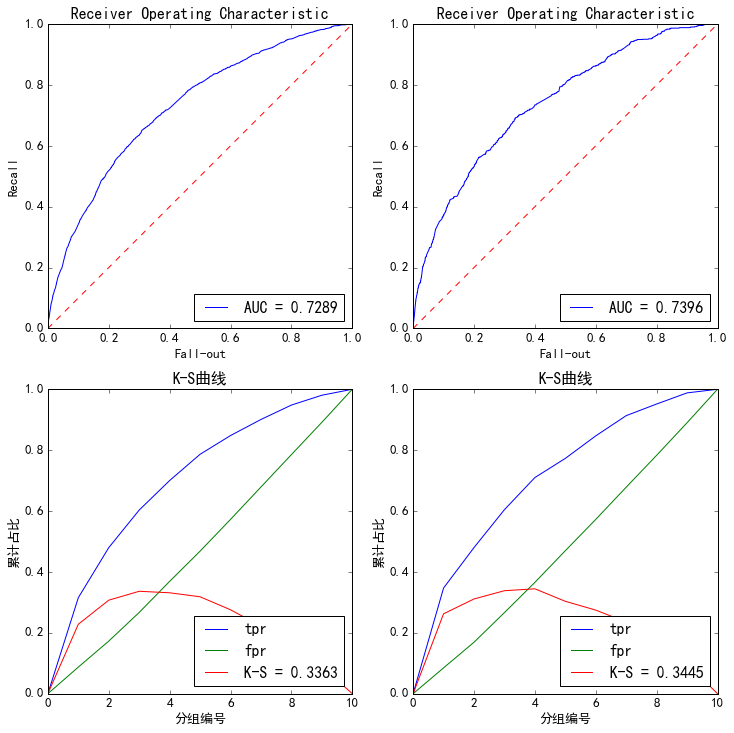

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


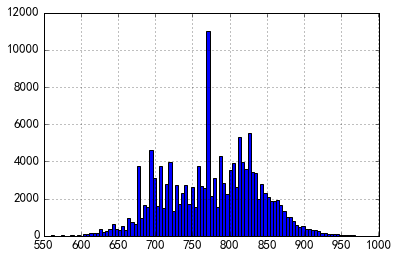

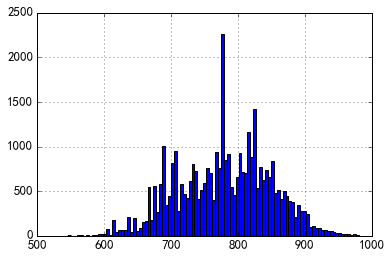

In [62]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_data_score.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_data_score.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.06179937]
回归系数为: [[ 0.58534314  0.41005661  0.13125418  0.85851769  0.9051854   0.5063601
   1.0254941   1.12410641]]


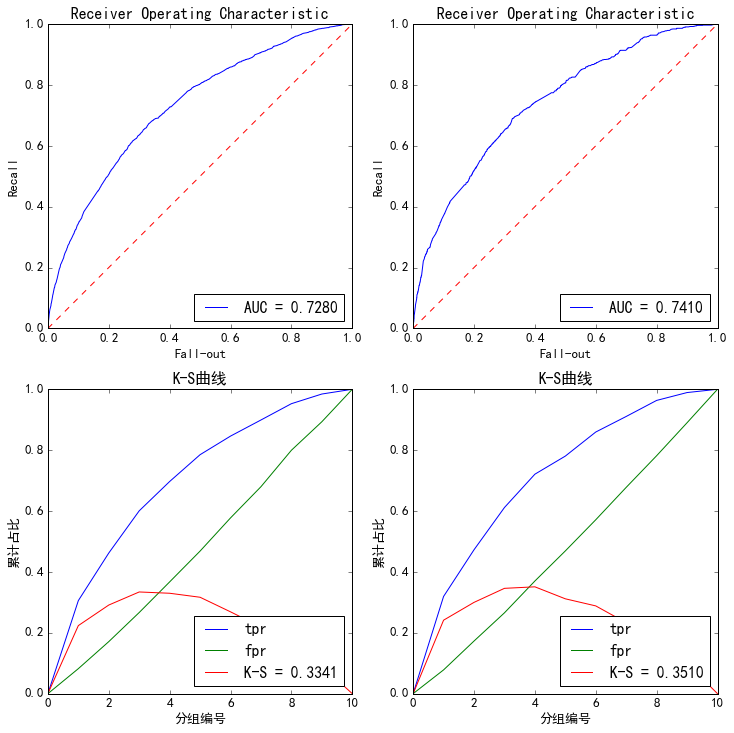

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


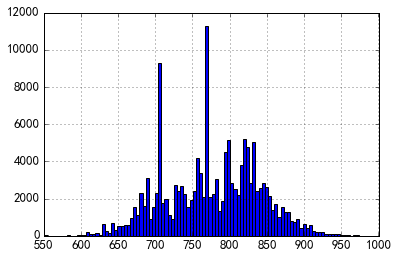

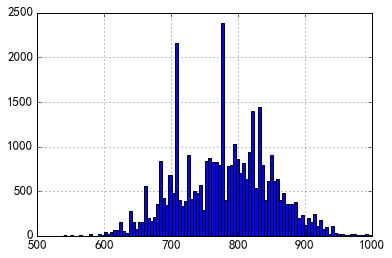

In [78]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_data_score_2.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_data_score_2.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.06133679]
回归系数为: [[ 0.98086233  0.91981827  0.46867196  0.64587061  1.13626773]]


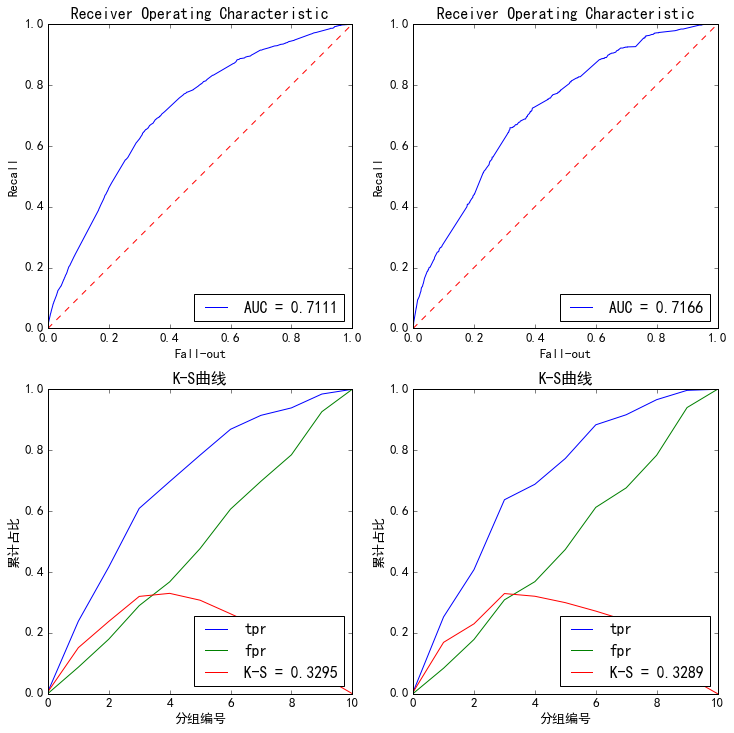

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


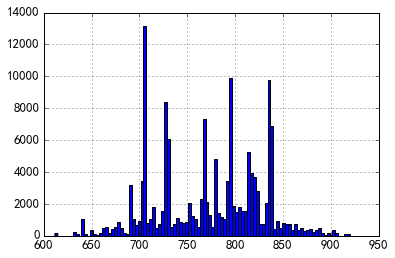

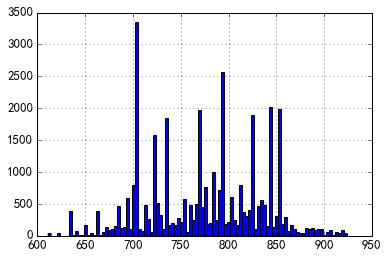

In [39]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_data_score_3.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_data_score_3.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.06174283]
回归系数为: [[ 0.67021639 -0.26611212  0.49901914  0.95298262  0.93868087  0.45832859
   1.12567095  1.17669885]]


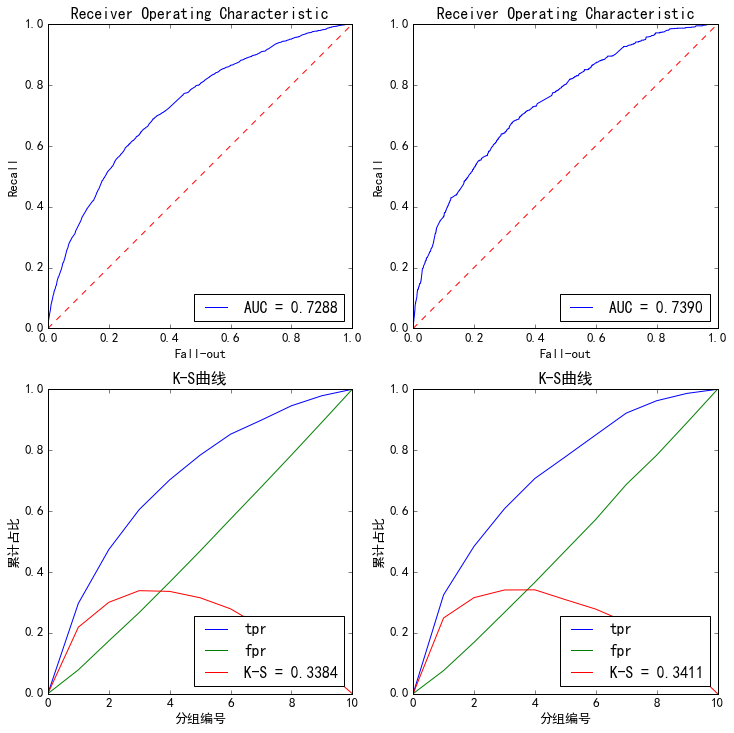

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


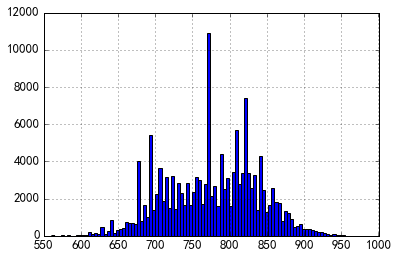

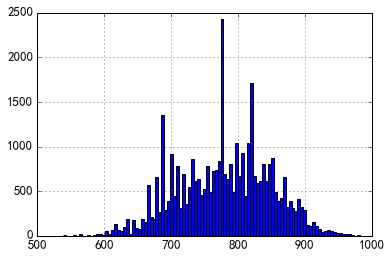

In [54]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_data_score_4.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_data_score_4.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.05918933]
回归系数为: [[ 0.70288542  0.93790502  0.92451169  0.46552126  1.2778051   1.17348471]]


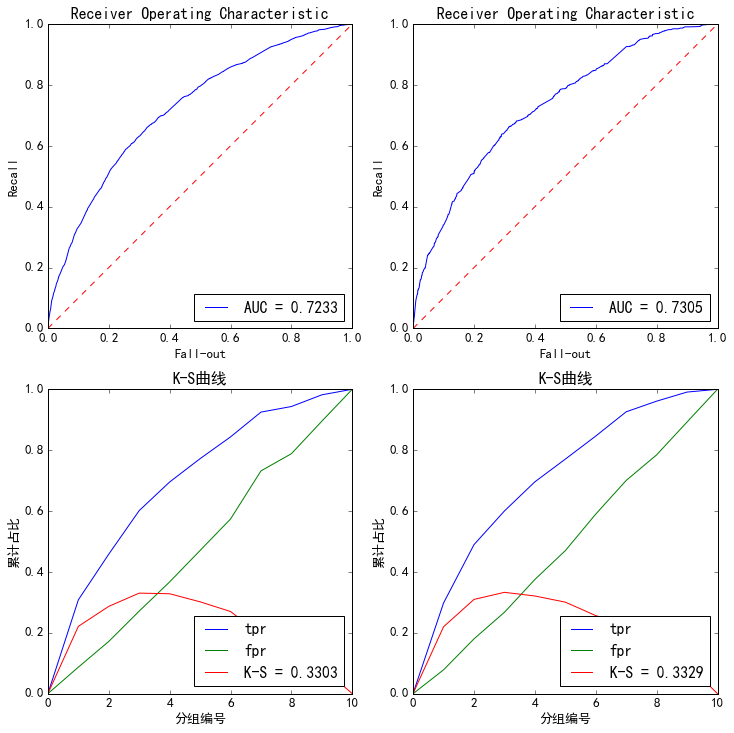

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


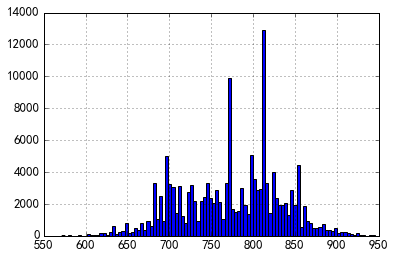

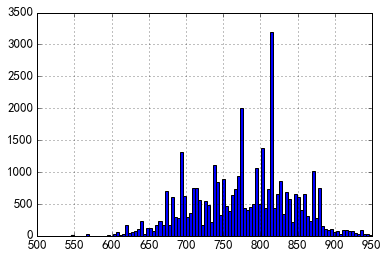

In [24]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_data_score_5.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_data_score_5.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.06002883]
回归系数为: [[ 0.55638539  0.360939    0.15645229  0.89726061  0.92214107  0.47200653
   1.10807056  1.17998841]]


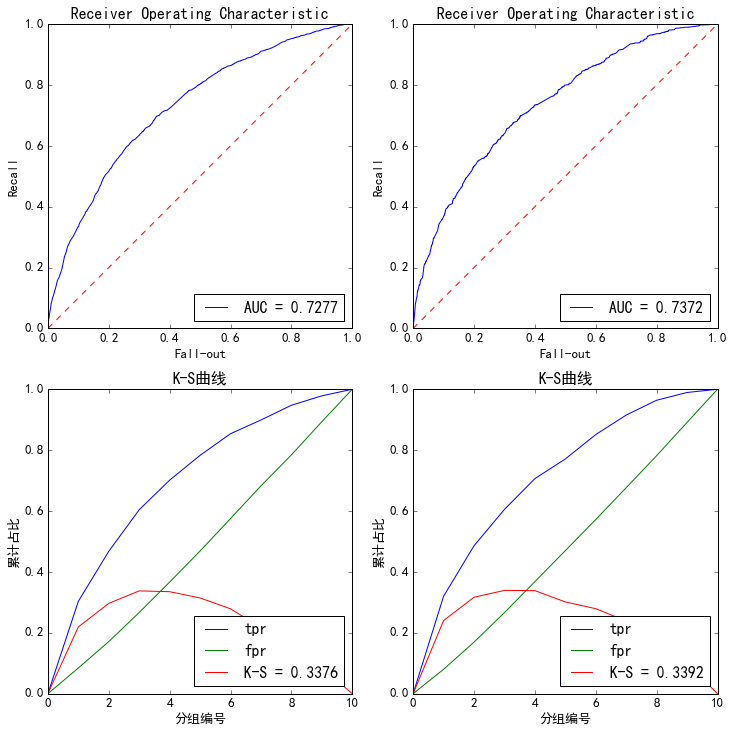

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


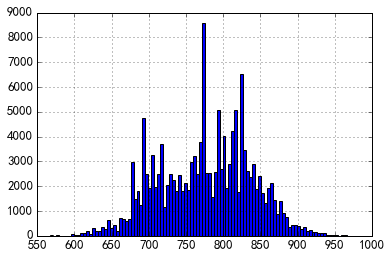

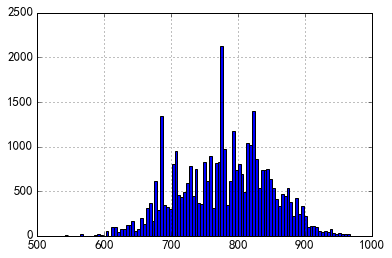

In [35]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_data_score_6.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_data_score_6.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.06216312]
回归系数为: [[ 0.55036702  0.35606286  0.15471224  0.87739542  0.98502577  1.10778895]]


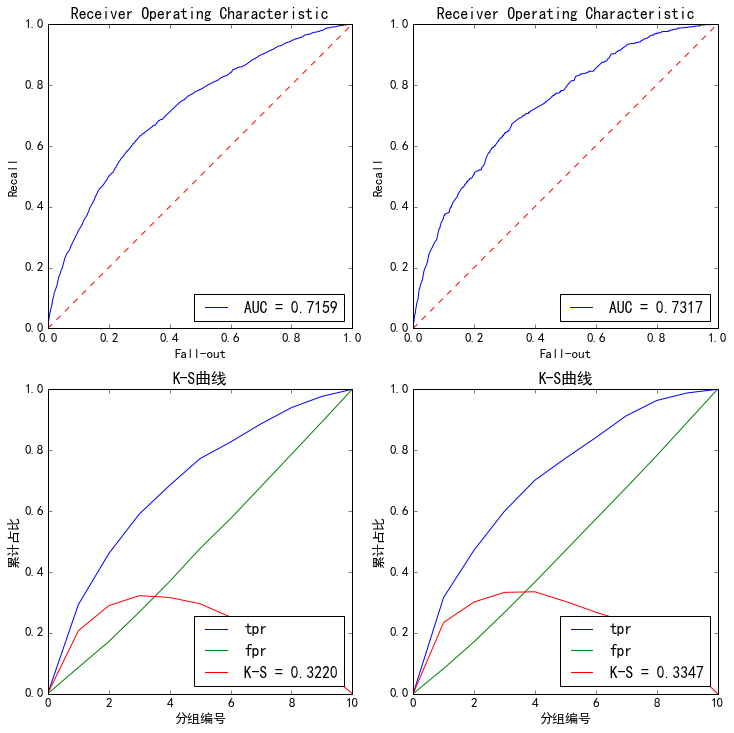

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


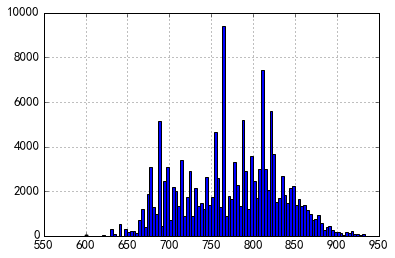

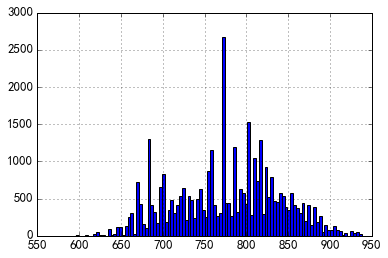

In [45]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_data_score_7.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_data_score_7.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_model_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_model_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)

# 契合业务对训练集和测试集都进行调箱

In [86]:
colnames = ['onehande_creditemail_rate_1month','onehande_creditemail_rate_6month','onehande_creditemail_rate_12month',\
                   'onehande_creditemail_rate_2month','credit_age','credit_email_num_1month','people_in_last_60','people_normal_in_last_180',\
                 'people_normal_in_last_year','amount_in_last_60','people_in_last_30','people_normal_in_last_30','people_in_last_15',\
                  'freq_in_last_60','people_normal_in_total','freq_normal_in_last_180','people_in_last_6','var_freq_miss_day',\
        'avg_people_in_month','people_normal_in_last_15','avg_amount_in_month','people_in_last_5','amount_in_last_30','freq_normal_in_total',\
                'max_people_in_month','people_in_last_3','people_normal_in_last_7','people_in_last_2','max_amount_in_month','avg_freq_in_month',\
         'avg_freq_miss_day','freq_in_last_30','amount_in_last_7','freq_other_in_last_7','freq_other_in_last_60','people_abnormal_out_last_30',\
             'amount_in_last_5','amount_in_last_4','amount_in_last_3','freq_other_in_last_15','people_abnormal_in_last_30','freq_in_last_5',\
                        'people_normal_in_last_3','people_in_last_1','max_freq_in_month','people_abnormal_out_last_60','people_out_last_60',\
        'freq_in_last_6','freq_in_last_2','var_people_miss_month','var_freq_miss_month','freq_normal_in_last_30','freq_abnormal_out_last_15',\
                    'max_amount_in_day','freq_in_last_3','freq_abnormal_out_last_30','people_normal_out_last_180','people_normal_in_last_1',\
                        'freq_abnormal_in_last_30','people_normal_out_last_year','people_abnormal_in_last_year_rate','avg_people_in_day',\
                        'contacts_distinct_num_1month','y']
model_feature = ['onehande_creditemail_rate_1month','onehande_creditemail_rate_6month','onehande_creditemail_rate_12month',\
                 'credit_email_num_1month','people_in_last_60','people_abnormal_out_last_30','credit_age','var_freq_miss_day','y']
train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_dataset.csv')[colnames]
test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_dataset.csv')[colnames]
colnames.remove('y')
box_values_2 =  pd.read_csv('D:/python/0119号样本重定义/有通信/box_values_2.csv')[colnames]
train_box_data = test_box(train_dataset,box_values_2)
test_box_data = test_box(test_dataset,box_values_2)
model_feature_finally = model_feature.copy()
model_feature_finally.remove('y')
box_values_2[model_feature_finally].to_csv('D:/python/0119号样本重定义/有通信/box_values_finally.csv',index=False)



D:\Anaconda\lib\site-packages\pandas\indexes\api.py:71: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 计算训练集、测试集woe、iv

In [105]:
train_adjust_box_data = adjust_box_data(train_box_data)
# test_adjust_box_data = adjust_box_data(test_box_data)
# ##计算调箱后每个分箱的情况
box_analysis,box_cols_analysis = adjust_box(train_adjust_box_data[model_feature])
# ##计算woe  iv
train_adjust_data_woe,train_cols_iv = data_woe(train_adjust_box_data[model_feature])
test_adjust_data_woe,test_cols_iv = data_woe(test_adjust_box_data[model_feature])
# #保存调整后的训练集和测试集数据
train_adjust_data_woe.to_csv('D:/python/0119号样本重定义/有通信/train_finally_woe_data.csv',index=False)
test_adjust_data_woe.to_csv('D:/python/0119号样本重定义/有通信/test_finally_woe_data.csv',index=False)

In [106]:
train_cols_iv

[['onehande_creditemail_rate_1month', 0.4115141312463424],
 ['onehande_creditemail_rate_6month', 0.27019891155014519],
 ['onehande_creditemail_rate_12month', 0.16442259561025999],
 ['credit_email_num_1month', 0.18176181038374081],
 ['people_in_last_60', 0.059842312175275809],
 ['people_abnormal_out_last_30', 0.036454644654441412],
 ['credit_age', 0.069080044240698968],
 ['var_freq_miss_day', 0.050257943424896999]]

In [110]:
pd.DataFrame(box_cols_analysis).to_csv('temp.csv',index=False)

# 训练模型

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


开始保存模型
回归截距是： [-6.06325612]
回归系数为: [[ 0.56735364  0.29032106  0.28947832  0.93705838  0.88916667  0.55082254
   1.04043531  1.12325879]]


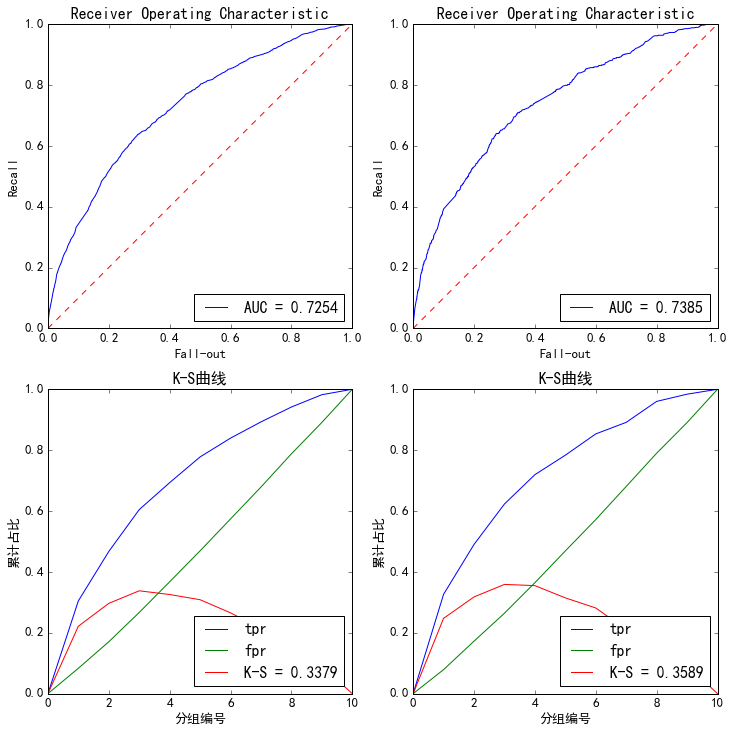

模型评价指标已保存在：D:/python/0119号样本重定义/有通信/LR_model_auc_ks.png
分数分布图：


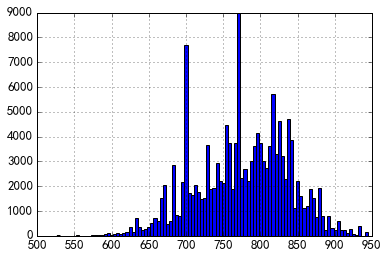

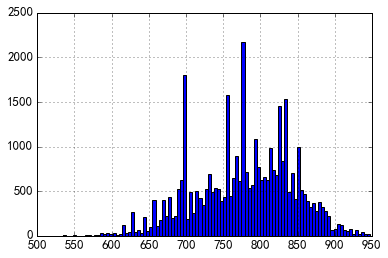

In [111]:
#保存模型、评价指标
def run_main(train_x,test_x,train_y,test_y):
    global lr_fit
    lr_fit = run_lr(train_x,train_y)
    auc_ks(train_x,test_x,train_y,test_y)
    print('模型评价指标已保存在：%s'%(file_LR_model_auc_ks))
    print('分数分布图：')
    #训练集成绩
    train_score = plt_bst(train_x,train_y,lr_fit)
    train_score['score'] = train_score['score']  
    train_score = train_score.round({'score':0})
    train_score.to_csv('train_score_finally.csv',index=False)
    #保存测试集成绩
    test_score = plt_bst(test_x,test_y,lr_fit)
    test_score['score']=test_score['score']
    test_score = test_score.round({'score':0})
    test_score.to_csv('test_score_finally.csv',index=False)
    
if __name__ == '__main__':
#训练及数据训练
    train_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/train_finally_woe_data.csv')
    test_dataset = pd.read_csv('D:/python/0119号样本重定义/有通信/test_finally_woe_data.csv')
    train_x = train_dataset.iloc[:,:-1]
    train_y = train_dataset[['y']]
    test_x = test_dataset.iloc[:,:-1]
    test_y = test_dataset[['y']]
    run_main(train_x,test_x,train_y,test_y)